# Laboratorio 06: Redes Recurrentes

**Objetivo:** Clasificar de apellidos, según su nacionalidad, utilizando un modelo simple de redes neuronales recurrentes. (A nivel de caracter) 

**Descripción:**

Construiremos y entrenaremos un RNN de nivel básico para clasificar palabras. Este tutorial, junto con los dos siguientes, muestra cómo hacer el preprocesamiento de datos para el modelado de un proceso de lenguaje natural (NPL) "desde cero". Se utilizarán algunas de las funciones  de *torchtext*, de modo que se pueda ver cómo el preprocesamiento para el modelado de NPL funciona a bajo nivel.

Una RNN a nivel de carácter lee las palabras como una serie de caracteres - produciendo una predicción y un "estado oculto" en cada paso, alimentando su estado oculto anterior en cada paso siguiente. Tomamos la predicción final como salida, es decir, a qué clase pertenece la palabra.

Específicamente, entrenaremos en unos pocos miles de apellidos de 18 idiomas de origen, y predeciremos de qué idioma proviene un nombre basándonos en la ortografía.



---
NLP From Scratch: Classifying Names with a Character-Level RNN

**Autor:** Sean Robertson <https://github.com/spro/practical-pytorch>_


In [ ]:
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

**Cargar los datos de Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive


## 1. Preparando los 
Bajar la base de datos de apellidos `aquí <https://download.pytorch.org/tutorial/data.zip>`.

Extraer estos en el directorio actual.

En ``data/names`` se encuentran 18 textos en archivos llamados "[lenguaje].txt". Cada archivo contiene apellidos, uno por línea, la mayoría normalizados (pero deben ser convertidos de Unicode a ASCII).

Terminaremos con un diccionario con listas de nombres por idioma,
``Idioma: [nombres ...]}``. Las variables genéricas "categoría" y "línea"
(para el lenguaje y el nombre en nuestro caso) se utilizan para su posterior ampliación.

In [ ]:
import unicodedata
import string
import glob
import os

PATH_TEXT = '/content/drive/My Drive/D-UCN/Classes/TecnicasAvanzadasAprendizajeAutomatico/Laboratorios/Laboratorio06:RedesRecurrentes/database/names'

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Convertir el código Unicode al texto ASCII (https://stackoverflow.com/a/518232/2809427)
def unicodeToAscii(s):
  return ''.join(
      c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn'
      and c in all_letters
  )

# print(unicodeToAscii('Ślusàrski'))

# Leer los archivos y los cargaremos en un estructura de tipo diccionario
category_lines = {}
all_categories = []

def readLines(filenames):
  lines = open(filename, encoding='utf-8').read().strip().split('\n')
  return [unicodeToAscii(line) for line in lines]

for filename in glob.glob(f'{PATH_TEXT}/*.txt'):
  category = os.path.splitext(os.path.basename(filename))[0]
  all_categories.append(category)
  lines = readLines(filename)
  category_lines[category] = lines

n_categories = len(all_categories)

Ahora tenemos `category_lines`, un diccionario que mapea cada categoría (idioma) a una lista de líneas (nombres). También llevamos un registro de `all_categories` (sólo una lista de idiomas) y `n_categories` para su posterior referencia.

In [ ]:
print(all_categories)

['Vietnamese', 'Spanish', 'Japanese', 'Korean', 'English', 'Scottish', 'German', 'Irish', 'Chinese', 'Polish', 'Italian', 'Russian', 'Dutch', 'Portuguese', 'French', 'Czech', 'Arabic', 'Greek']


In [ ]:
print(category_lines['Greek'][:5])

['Adamidis', 'Adamou', 'Agelakos', 'Akrivopoulos', 'Alexandropoulos']


## 2. Convirtiendo los nombres a tensores

Ahora que tenemos todos los nombres organizados, necesitamos convertirlos en
Tensores para hacer cualquier uso de ellos.

Para representar una sola **letra**, usamos un "***one-hot vector***" de tamaño `<1 x n_letters>`. Un vector de una letra (***one-hot vector***), consiste en un arreglo que contiene ceros y un (uno solo) en el índice de la letra que se quiere representar. Por ejemplo, `"b"= <0 1 0 0 0 ...>`.

Para representar una **palabra** unimos varios vectores de una letra en una matriz 2D `<line_length x 1 x n_letters>`.

La dimesión 1 extra indica a Pytorch que esa estructura está en lotes (*batch*), indicando que el tamaño del lote es uno.


## 3. Creando la red

Antes del *autograd*, la creación de una red neural recurrente en Torch implicaba
clonar los parámetros de una capa en varios pasos de tiempo. Las capas
mantenían estados y gradientes ocultos que ahora son manejados enteramente por la librería. Esto significa que puedes implementar un RNN de una manera muy "pura", como capas regulares de alimentación...

Este módulo RNN (en su mayoría copiado de "The PyTorch for Torch users")
tutorial <https://pytorch.org/tutorials/beginner/former_torchies/
nn_tutorial.html#example-2-recurrent-net>`__)
son sólo 2 capas lineales que operan en un estado de entrada y oculto, con
una capa de LogSoftmax después de la salida.

Figura:: https://i.imgur.com/Z2xbySO.png

Figura [(softmax)](https://cdn-images-1.medium.com/freeze/max/1000/1*ghDbeGZZUloPOJK7g3OyBg.png?q=20)::



Para ejecutar un paso de esta red necesitamos pasar una entrada (en nuestro caso, el
Tensor para la letra actual) y un estado oculto anterior (que nosotros
inicializar como ceros al principio). Recuperaremos la salida (probabilidad de
cada idioma) y un siguiente estado oculto (que guardamos para el próximo
paso).

Para mejorar la eficiencia no queremos crear un nuevo Tensor para
cada paso, así que usaremos ``lineToTensor`` en lugar de
``letterToTensor`` y usa *slices*. Esto podría ser optimizado aún más por
precomputando lotes de Tensores.

Como puedes ver, la salida es un tensor ``<1 x n_categories>``, donde
cada *item* es la probabilidad de esa categoría (más alta es más probable).

## 4. Entrenando la red

Preparando los datos
--------------------

Antes de entrar en el entrenamiento debemos hacer algunas funciones de ayuda. La primera es interpretar el resultado de la red, que sabemos que es una probabilidad de cada categoría. Podemos usar Tensor.topk para obtener el índice de mayor valor:

('Portuguese', 13)


También queremos una forma rápida de obtener un ejemplo de entrenamiento (un nombre y su
idioma):

Entrenamiento de la red
--------------------

Ahora todo lo que se necesita para entrenar a esta red es mostrarle un montón de ejemplos.

Para la función de pérdida `n.NLLLoss` es apropiado, ya que la última
La capa del RNN es `nn.LogSoftmax`.

Cada ciclo de entrenamiento hará:

1. Crear tensores de entrada y de destino

2. Crear un estado inicial oculto igual a cero

3. Leer cada letra y mantener el estado oculto para la próxima letra.

4. Comparar el resultado final con el objetivo

5. *Back-propagate*

6. Devolver la salida y la pérdida

Ahora sólo tenemos que correr esto con un montón de ejemplos. Como la función del entrenamiento devuelve tanto la salida como la pérdida, podemos imprimir sus predicciones y también llevar la cuenta de la pérdida. Ya que hay miles de ejemplos, imprimimos sólo cada uno de ellos y tomamos un promedio de la pérdida.

## 5. Graficando los resultados

Graficar la pérdida histórica de `all_loses` muestra el aprendizaje de la red.

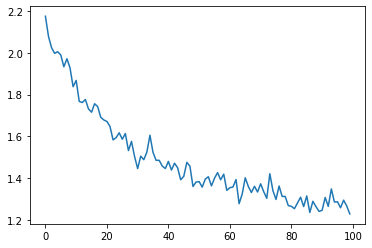

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

# 6. Evaluando los resultados

Para ver cómo funciona la red en diferentes categorías, vamos a
crear una **matriz de confusión**, indicando para cada idioma real (filas)
qué idioma adivina la red (columnas). Para calcular la confusión
matriz un montón de muestras se ejecutan a través de la red con
`Evaluar`, que es lo mismo que `Entrenar`, menos el respaldo.

In [ ]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

Puedes elegir los puntos más brillantes en el eje principal que muestren qué
idiomas que adivina incorrectamente, por ejemplo, el chino para el coreano, y el español para el italiano. Parece que le va muy bien con el griego, y muy mal con Inglés (tal vez debido a la superposición con otros idiomas).

In [ ]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')
predict('Bekios')

La versión completa del código la pueden revisar en <https://github.com/spro/practical-pytorch/tree/master/char-rnn-classification>`